<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Analisis_salto_vertical_Fuerzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis del salto vertical a partir de las fuerzas de reacción del suelo
Jose Luis López Elvira ([enlace a más recursos en GitHub](https://github.com/joselvira/BiomecanicaPython))

Última modificación 06/07/2021

En este notebook vamos a tratar de describir y analizar los principales test de salto que se emplean para valorar la capacidad de los deportistas de generar fuerza explosiva en el tren inferior. 

Primero cargamos las librerías básicas que utilizaremos.

In [ ]:
import numpy as np #tipo de datos Numpy
import pandas as pd #tipo de datos Pandas
import matplotlib.pyplot as plt #librería básica para representar gráficas

Empezaremos cargando en memoria un archivo con las fuerzas registradas en un **salto vertical con contramovimiento o CMJ** (del inglés *Counter Movement Jump*).

En este caso, se trata de un registro realizado con una plataforma de fuerzas de la marca *Kistler* con su propio software *Bioware*.

Por simplificar en este ejemplo, accedemos directamente al archivo concreto que se encuentra en el repositorio de Github [BiomecanicaPython](https://github.com/joselvira/BiomecanicaPython). Si quisieras abrir un archivo alojado localmente en tu ordenador, simplemente tendrías que meter en la variable *nom_arch_salto* la ruta donde se encuentre el archivo. Si estás ejecutando este notebook desde *Google Colaboratory*, por motivos de seguridad, tendrás que acceder primero al archivo por alguno de los métodos que permite el entorno.

Es conveniente antes de ponerse a trabajar con el archivo, ver qué contiene. Como es un archivo de texto se puede abrir con cualquier lector de archivos de texto, como el Bloc de Notas en el entorno Windows.

In [ ]:
from IPython.display import Image
Image(url='https://github.com/joselvira/BiomecanicaPython/raw/master/Imagenes/ArchivoSaltosCrudo.png', height=400)

Como se ve en la imagen anterior, el archivo empieza con una serie de datos sobre cómo se realizó el registro, que ahora no nos interesan.

El encabezado con la descripción de los datos empieza en la fila número 17 (la primera se cuenta como cero), y los datos en sí en la fila 19. Esto es importante conocerlo para poder realizar correctamente el proceso de lectura del archivo. En total hay cuatro columnas de datos, la primera corresponde al tiempo en segundos, y las otras a las fuerzas en los tres ejes del espacio.

En la siguiente celda se utiliza la librería *Pandas* para cargar el archivo. Fíjate que se indica la fila del encabezado (header=17) y que se salte la fila 18 (skiprows=[18]), que solamente incluye las unidades. Finalmente, el separador que utilizan estos archivos es el tabulador, que se representa con el símbolo \t.

In [ ]:
nom_arch_salto = 'https://raw.githubusercontent.com/joselvira/BiomecanicaPython/master/Datos/PlatFuerzas/Saltos/BiowareSaltos-5.txt' #archivo con el registro de las fuerzas en un salto.
separador= '\t'

dfDatos = pd.read_csv(nom_arch_salto, header=17, skiprows=[18], sep=separador)
dfDatos

,abs time (s),Fx,Fy,Fz
0,0.000,-1.968899,-1.053477,602.418762
1,0.001,-2.288167,-1.372931,600.676270
2,0.002,-2.448239,-1.532773,599.248703
3,0.003,-2.288167,-1.492755,600.992996
4,0.004,-1.968899,-1.213090,602.578865
...,...,...,...,...
7995,7.995,-1.519445,-0.863344,601.274384
7996,7.996,-1.559830,-0.783537,601.433578
7997,7.997,-1.958986,-1.222357,598.737740
7998,7.998,-1.999078,-1.182570,599.369911


Echamos un primer vistazo a los datos, representándolos gráficamente. Como se puede apreciar, la gráfica corresponde a las fuerzas en un salto vertical típico con contramovimiento.

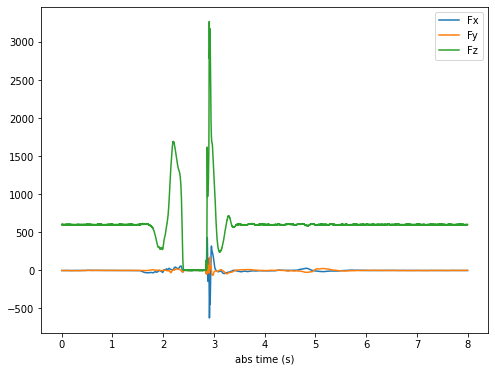

In [ ]:
dfDatos.plot(x='abs time (s)', figsize=(8,6))

Por simplificar, pasamos las variables que vamos a analizar a variables numpy. Nos interesa especialmente la columna del tiempo (con encabezado 'abs time (s)') y la fuerza vertical (con encabezado 'Fz').

In [ ]:
t = dfDatos['abs time (s)'].to_numpy() #tiempo
Fz = dfDatos['Fz'].to_numpy() #fuerza vertical
frec = 1/(t[1]-t[0]) #frecuencia de registro


Empezaremos por **calcular el peso**, ya que es necesario para calcular otras variables que utilizaremos más adelante. La fuerza que nos proporciona el peso del saltador es la fuerza vertical, puesto que **mientras la persona está de pie quieta sobre la plataforma**, la fuerza que ejerce contra el suelo es la debida a la atracción de la gravedad, es decir, el peso.

En la siguiente imagen se representa el diagrama de cuerpo libre de la persona que permanece de pie sobre la plataforma. Mientras no se mueva, está recibiendo dos fuerzas que se oponen: 1) la fuerza peso (P hacia abajo) que se aplica en su centro de gravedad; y 2) la fuerza de reacción del suelo (Fz hacia arriba) que surge del contacto de sus pies con el suelo.

Mientras esas dos fuerzas sean iguales, no se produce ninguna aceleración y puede permanecer quieto.



In [ ]:
Image(url='https://github.com/joselvira/BiomecanicaPython/raw/master/Imagenes/CMJ_1_Equilibrio.png', height=400)

Adaptado de López Elvira (1998).

Sin embargo, antes de pasar a medir el peso sobre los datos, debemos tener en cuenta un aspecto que tiene que ver con cómo miden las plataformas de fuerzas y en general, cualquier aparato eléctrico.

Aunque en la gráfica general se vean las líneas bastante suavizadas, en realidad siempre se cuela ruido en la señal. En la siguiente gráfica puedes ver un tramo de la fuerza vertical ampliado, como si hiciéramos zoom sobre la gráfica, que corresponde a la parte en la que el saltador está en el aire y la fuerza sobre la plataforma debería ser cero. Observa cómo **se producen dientes de sierra en torno al cero, esto es debido al ruido de alta frecuencia que proviene de la red eléctrica** y que queda registrado por el aparato.

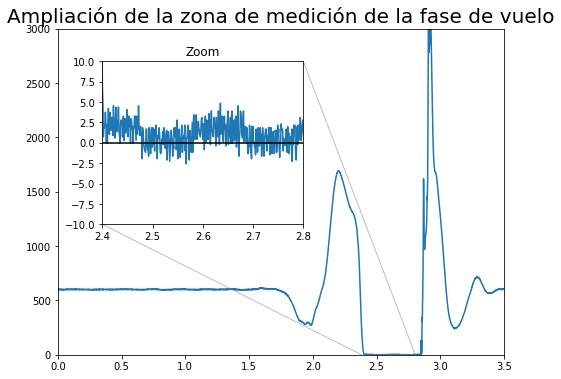

In [ ]:
#Figura ampliada de la fuerza vertical
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 3.5), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.1, 0.4, 0.45, 0.5]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)

ax_zoom.axhline(0.0, color='k')

ax_zoom.set(title='Zoom', xlim=(2.4, 2.8), ylim=(-10, 10)) #los valores de xlim son unidades de tiempo (segundos) y a del ylim unidades de fuerza (newtons)

ax.set_title('Ampliación de la zona de medición de la fase de vuelo', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

Es por esto por lo que para medir el peso no podemos tomar un valor puntual de los datos de fuerza vertical, sino que **debemos hacer un promedio de un tramo del salto en el que la fuerza vertical sea estable**. Normalmente en los CMJ se hace en la parte inicial. Por eso, cuando se hace el registro de los saltos es conveniente poner en marcha la plataforma unos 2 s antes de dar al saltador la señal de que se empiece a mover.

En este caso, realizaremos el promedio entre los datos 500 y 1000. Sabiendo que la plataforma estaba configurada para registrar con una frecuencia de 1000 Hz, quiere decir que estamos midiendo en una ventana de medio segundo.

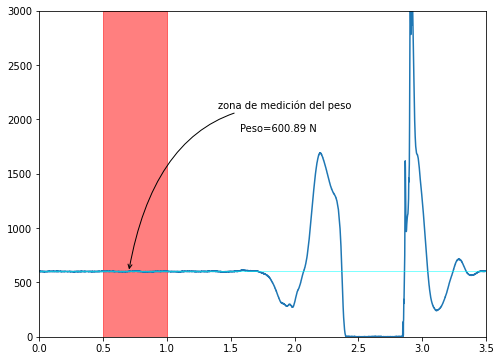

In [ ]:
ini_peso = 500 #índice donde empieza la ventana para medir el peso 
fin_peso = ini_peso + 500 #índice donde termina la ventana para medir el peso
peso = Fz[ini_peso:fin_peso].mean()

#Presenta los datos
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(t, Fz)
#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 3500/frec), ylim=(0, 3000))

ax.axhline(peso, color='cyan', lw=0.5)
ax.axvspan(ini_peso/frec, fin_peso/frec, alpha=0.5, color='r')

ax.annotate('zona de medición del peso',
            xy=(700/frec, peso), xycoords='data',
            xytext=(0.4, 0.7), textcoords='axes fraction', #en este caso, las coordenadas del texto son relativas al tamaño del cuadro de los ejes (de 0 a 1)
            arrowprops=dict(arrowstyle='->', color='black', connectionstyle='angle3,angleA=0,angleB=80')) #con algle3 se puede especificar el ángulo de la flecha al inicio y al final

ax.text(0.45, 0.63, 'Peso={0:.2f} N'.format(peso), transform=ax.transAxes)

plt.show()

Es conveniente realizar la medición del peso en los datos particulares de cada registro, aunque se trate de la misma persona realizando varios saltos durante la misma sesión. Esto es importante porque puede haber ligeras variaciones en cada medición por causas externas, y los cálculos que realizaremos a posteriori son muy sensibles al valor de peso utilizado.

## Búsqueda del inicio del salto

Una vez conocemos el peso de la persona que realizó el salto, tenemos que ser capaces de **detectar automáticamente cuándo se produce el inicio del movimiento**. Esto va a ser distinto dependiendo del tipo de salto de que se trate. En este ejemplo, se trata de un CMJ, por lo que el inicio del salto se produce cuando el valor de fuerza vertical desciende respecto al valor del peso. Sería fácil detectar cuándo se produce esto buscando en qué instante la variable Fz es menor que la variable peso, sin embargo, como hemos visto anteriormente, la medición de la fuerza incluye ruido inherente al aparato de medida, y por otra parte, la persona puede realizar ciertos movimientos inapreciables a simple vista pero que la plataforma es capaz de medir. Por eso, debemos utilizar un algoritmo más robusto, que evite falsos positivos, y que sea aplicable a cualquier salto.

Se suelen aplicar dos aproximaciones:

1. Buscar cuándo Fz es menor que un porcentaje del peso, por ejemplo, el 90%.

2. Buscar cuándo Fz es menor que un umbral que tenga en cuenta el propio ruido de la señal, normalmente restando al peso un número de veces la desviación típica (SD) de la zona donde se midió el peso.

En este caso, **utilizaremos el criterio de la desviación típica**, estableciendo como umbral de detección del inicio del salto el peso menos cinco veces la desviación típica de Fz en la zona donde medimos el peso.

In [ ]:
#BUSCA EL INICIO DEL SALTO USANDO COMO UMBRAL 5 DESVIACIONES TÍPICAS DEL REGISTRO DE FUERZA EN LA ZONA ESTABLE DE MEDICIÓN DEL PESO
umbral_ini = peso-5*Fz[ini_peso:fin_peso].std()
print(umbral_ini)

592.1684750675122


Para visualizar lo que hemos hecho, creamos una gráfica con el perfil de la fuerza vertical y una ventana ampliada de la zona donde se mide el peso. La línea azul oscuro representa la media, es decir el peso, y la línea roja discontínua el umbral usado para detectar el inicio del salto ($peso-5 \times SD$).

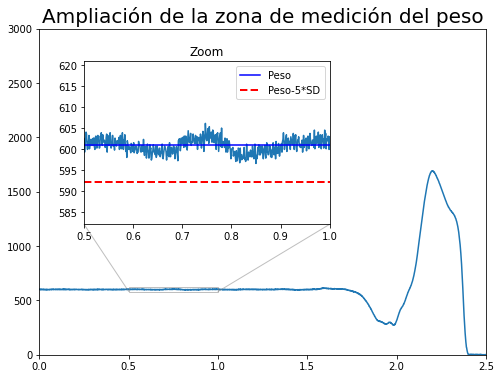

In [ ]:
#Figura ampliada del peso y el umbral
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 2500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.1, 0.4, 0.55, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)
ax_zoom.axhline(peso, color='b', label='Peso') #línea del peso
ax_zoom.axhline(umbral_ini, color='r', linestyle='--', lw=2, label='Peso-5*SD') #umbral usado para determinar el inicio del movimiento 

ax_zoom.legend()
ax_zoom.set(title='Zoom', xlim=(ini_peso/frec, fin_peso/frec), ylim=(umbral_ini-10, peso+20))

ax.set_title('Ampliación de la zona de medición del peso', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

Para detectar instantes automáticamente, se pueden utilizar distintas estrategias. Aquí vamos a usar una librería muy útil creada por Marcos Duarte llamada [*detecta*](https://pypi.org/project/detecta/). En primer lugar la instalamos en el sistema y luego la importamos para poder usarla.

In [ ]:
#Instala librería detecta (Marcos Duarte)
!pip install detecta

from detecta import detect_onset

Y utilizamos la función *detect_onset* para encontrar los instantes en los que la fuerza supera el umbral.

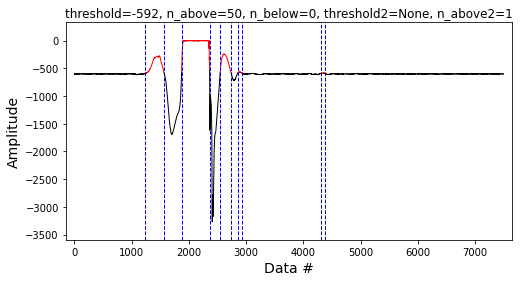

In [ ]:
indices = detect_onset(-Fz[ini_peso:], -umbral_ini, n_above=50, n_below=0, show=True) #empieza a buscar desde que iniciamos la medida del peso
ini_salto = indices[0,0]+ini_peso #se suma iniPeso porque hemos empezado a buscar desde el inicio de la medida del peso


Fíjate en que pasamos como argumento de la función la señal Fz invertida. Esto es porque busca cuándo la señal supera el umbral que le indiquemos, en este caso guardado en la variable *umbral_ini* que habíamos definido previamente.

La función devuelve una serie de listas con dos datos cada una, que representan los índices en los que la señal supera el umbral y desciende por debajo. En este caso las guardamos en la variable *indices*. Podemos ver qué ventanas ha encontrado en este ejemplo.

In [ ]:
print(indices)

[[1237 1568]
 [1872 2362]
 [2546 2740]
 [2851 2933]
 [4314 4374]]


Como sabemos que en el CMJ el saltador empieza manteniéndose quieto, podemos deducir que la primera vez que se supera el umbral umbral_ini es donde ha empezado a moverse. Podemos mostrarlo gráficamente.

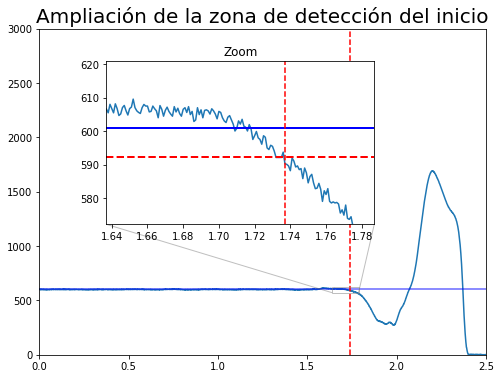

El inicio del salto se detecta a los 1.737 s desde el inicio del registro.


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)
ax.axhline(peso, color='b', alpha=0.6)
ax.axvline(ini_salto/frec, c='r', ls='--')

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 2500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.15, 0.4, 0.60, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)
ax_zoom.axhline(umbral_ini, color='r', linestyle='--', lw=2)
ax_zoom.axhline(peso, color='b', lw=2)
ax_zoom.axvline(ini_salto/frec, c='r', ls='--')

ax_zoom.set(title='Zoom', xlim=((ini_salto-100)/frec, (ini_salto+50)/frec), ylim=(umbral_ini-20, peso+20))# , xticks=[-1,0,1], yticks = [-0.01, 0, 0.01, 0.02])

ax.set_title('Ampliación de la zona de detección del inicio', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

print('El inicio del salto se detecta a los {:.3f} s desde el inicio del registro.'.format(ini_salto/frec))

Con este procedimiento sabemos con certeza que se ha iniciado el movimiento porque hemos fijado el umbral por debajo de x deviaciones típicas del peso, pero tiene el inconveniente de que nos hemos pasado un poco en el tiempo. Recuerda que fijamos el umbral en varias desviaciones típicas por debajo del peso para evitar falsos positivos, pero esto hace que cuando se detecte el inicio, ya lleva un rato por debajo del peso real.

Pero **podemos afinar aún más la detección del evento de inicio** buscando hacia atrás hasta que se alcance el valor del peso.

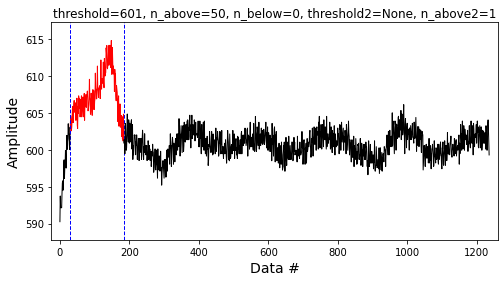

Inicio del movimiento del salto encontrado en la posición 1709


In [ ]:
#Para un ajuste más fino, ahora busca hacia atrás hasta el peso
indices=detect_onset(Fz[ini_salto:ini_peso:-1], peso, n_above=50, n_below=0, show=True)
ini_salto-=indices[0,0]-1 #resta a la variable ini_salto que teníamos el tramo que ha encontrado hasta el peso
print('Inicio del movimiento del salto encontrado en la posición', ini_salto)

Fíjate en que el primer argumento de la función (*Fz[ini_salto:ini_peso:-1]*) es la fuerza vertical invertida en el tiempo desde el inicio del salto detectado hasta el instante donde se empieza a calcular el peso.

Y lo volvemos a mostrar gráficamente.

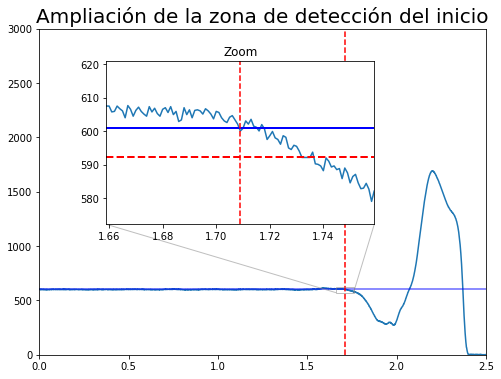

El inicio del salto se produce a los 1.709 s desde el inicio del registro.


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)
ax.axhline(peso, color='b', alpha=0.6)
ax.axvline(ini_salto/frec, c='r', ls='--')

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 2500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.15, 0.4, 0.60, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)
ax_zoom.axhline(umbral_ini, color='r', linestyle='--', lw=2)
ax_zoom.axhline(peso, color='b', lw=2)
ax_zoom.axvline(ini_salto/frec, c='r', ls='--')

ax_zoom.set(title='Zoom', xlim=((ini_salto-50)/frec, (ini_salto+50)/frec), ylim=(umbral_ini-20, peso+20))# , xticks=[-1,0,1], yticks = [-0.01, 0, 0.01, 0.02])

ax.set_title('Ampliación de la zona de detección del inicio', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

print('El inicio del salto se produce a los {:.3f} s desde el inicio del registro.'.format(ini_salto/frec))

Ahora tenemos el instante en el que se ha empezado a mover el saltador guardado en la variable *ini_salto*.

## Búsqueda del tiempo de vuelo

En este caso se trata de detectar cuándo la fuerza se encuentra cercana al cero. La fase de vuelo comienza cuando el saltador despega de la plataforma, es decir, cuando la fuerza vertical es cero, y termina cuando el saltador vuelve a entrar en contacto con la plataforma, es decir, cuando la fuerza aumenta por encima de cero. Sin embargo, como ya dijimos anteriormente, siempre se cuela algo de ruido en la señal de la plataforma, por lo que la fuerza nunca será exactamente cero.

En cualquier caso, encontrar el tiempo de vuelo es más fácil que encontrar el inicio del movimiento del saltador, porque podemos fijar un umbral más claro que no dependa del ruido inherente a la señal. Por ejemplo, **podemos utilizar un umbral de 10 N para detectar el despegue y el aterrizaje**.

Volvemos a utilizar la función *detect_onset* para encontrar los instantes.

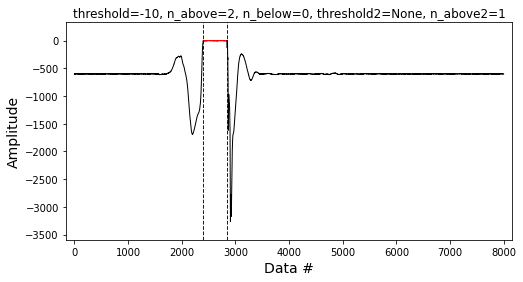

In [ ]:
umbral_vuelo=10.0

ind_vuelo = detect_onset(-Fz, -umbral_vuelo, n_above=2, n_below=0, show=True)
despegue = ind_vuelo[0,0]
aterrizaje = ind_vuelo[0,1]


En este caso, encuentra solo una ventana en la que los datos estén por debajo del umbral fijado. Esos dos instantes corresponden al despegue y al aterrizaje.

In [ ]:
print(ind_vuelo)

[[2400 2847]]


Una vez conocemos cúando se produce el despegue y el aterrizaje, podemos calcular el tiempo de vuelo con la ecuación:

$h=\frac{g\times t^2}{8}$

Donde *h* es la altura alcanzada, *g* es la aceleración de la gravedad, y *t* es el tiempo de vuelo.

In [ ]:
#El tiempo de vuelo sería:
tv = (aterrizaje-despegue)/frec

#y la altura es:
h = 9.8*tv**2/8
print('El tiempo de vuelo es {:.2f} m'.format(h))

El tiempo de vuelo es 0.24 m


En la siguiente gráfica podemos ver resaltada la ventana correspondiente al tiempo de vuelo detectado automáticamente.

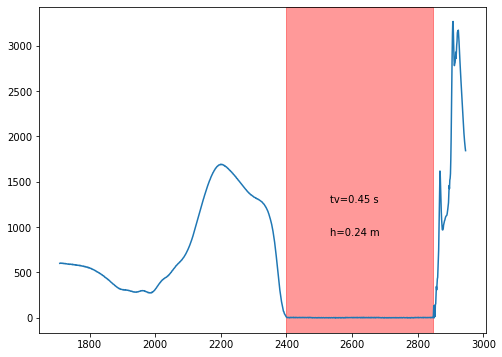

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(ini_salto, aterrizaje+100), Fz[ini_salto:aterrizaje+100])
ax.axvspan(despegue, aterrizaje, alpha=0.4, color='r')

#Muestra en la gráfica el tiempo de vuelo y la altura con solo 2 decimales
ax.text(0.65, 0.4, 'tv={0:.2f} s'.format(tv), transform=ax.transAxes) 
ax.text(0.65, 0.3, 'h={0:.2f} m'.format(h), transform=ax.transAxes)
plt.show()

# Cálculo de variables relacionadas con el movimiento del centro de gravedad

Muchas de las variables que nos interesa conocer para describir la capacidad de generar fuerza explosiva del deportista, dependen de la magnitud *impulso mecánico*. Esta magnitud ($F \times t$), se puede representar gráficamente como el área que queda por debajo de la fuerza en una gráfica *Fuerza/tiempo*.

En un salto vertical, la fuerza debida al peso no nos interesa porque no es generada por el deportista, por lo que la restamos en el cálculo del impulso. De este modo,  lo que calculamos es el **área que queda entre la gráfica de fuerza vertical y el peso**. En la siguiente gráfica se representa el impulso mecánico, en verde el positivo (que hace ganar velocidad vertical), y en rojo el negativo (que hace perder velocidad vertical).

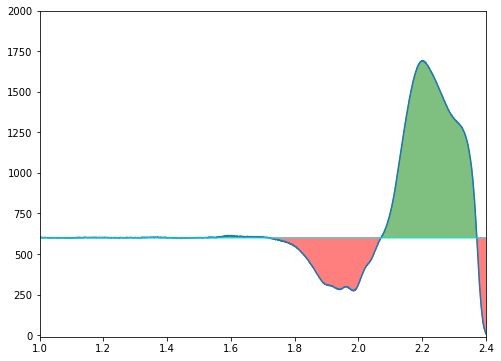

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(t,Fz)
ax.axhline(peso, color='cyan', alpha=0.6)

ax.fill_between(t, peso, Fz, where= Fz>peso, color='g', alpha=0.5) #rellena impulso positivo
ax.fill_between(t, peso, Fz, where= Fz<peso, color='r', alpha=0.5) #rellena impulso negativo

#Ajusta límites del eje X e y
ax.set_xlim(fin_peso/frec, despegue/frec)
ax.set_ylim(-10, 2000)
plt.show()


Para empezar a calcular variables, traducimos la fuerza a aceleración, siguiendo la segunda ley de Newton:

$F=m \times a$

ATENCIÓN: Como la fuerza que mide la plataforma es una fuerza global que representa todas las fuerzas y acciones que realiza el cuerpo del saltador, todas las variables que calculemos a partir de esa fuerza representan el comportamiento del centro de gravedad del cuerpo.

Empezamos calculando la **aceleración**.

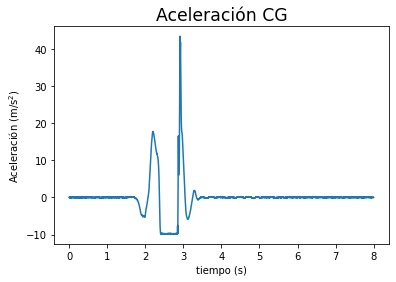

In [ ]:
aceleracion=(Fz-peso)/(peso/9.8)

plt.plot(t, aceleracion)
plt.xlabel('tiempo (s)')
plt.ylabel('Aceleración (m/s$^2$)')
plt.title('Aceleración CG', fontsize='xx-large')
plt.show()

Como se puede apreciar, la aceleración es proporcional a la fuerza (escalada por la masa), por lo que su perfil es idéntico al de la fuerza.

Por otra parte, la **velocidad** es la integral de la aceleración respecto al tiempo. Para calcularla se puede utilizar una función del módulo scipy. 

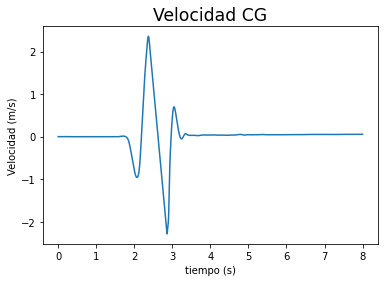

In [ ]:
import scipy.integrate as integrate

veloc= integrate.cumtrapz(aceleracion, dx=1/frec, initial=0)

plt.plot(t, veloc)
plt.xlabel('tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title('Velocidad CG', fontsize='xx-large')
plt.show()

**El cálculo de la velocidad es muy sensible a la dato de peso que se utilice**, y en ocasiones sucede que la velocidad tiende a aumentar o a disminuir con el tiempo produciendo un *drift* o deriva. En la figura anterior se ve aceptable porque la velocidad se encuentra en torno a cero tanto al principio como al final del salto.

Por otra parte, la **posición o desplazamiento** del centro de gravedad es la integral de la velocidad respecto al tiempo. Utilizamos la misma estrategia que antes para calcular la velocidad a partir de la aceleración.

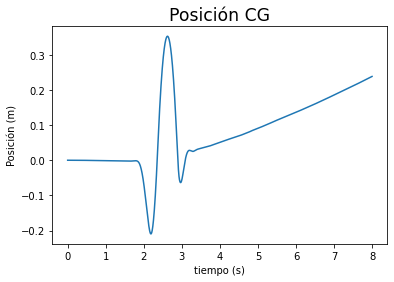

In [ ]:
posicion=integrate.cumtrapz(veloc, dx=1/frec, initial=0)
plt.plot(t, posicion)

plt.xlabel('tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Posición CG', fontsize='xx-large')
plt.show()

En este caso, fíjate en ascenso brusco que sufre la posición después de la caída. Lo esperable sería que la posición empezara estable en cero y terminara también siendo estable en cero, puesto que el saltador empieza y termina en la misma posición. Sin embargo, la posición se calcula integrando dos veces la aceleración, y como decía anteriormente, el cálculo es muy sensible a qué valor de peso se utilice. **Pequeños errores en la medida del peso se van acumulando con el tiempo**.

Suele ser frecuente que el impacto brusco contra el suelo que se produce tras el aterrizaje, el cálculo de la posición se dispare hacia arriba o hacia abajo.

Para probar el impacto de tienen desajustes en la medida del peso que se utiliza para calcular la velocidad y la posición del centro de gravedad, modifica el control deslizante de la siguiente celda y comprueba cómo afecta a las gráficas de la velocidad y posición. En la gráfica del ejemplo, el peso calculado mediante el promesio son aproximadamente 600 N, y el control deslizante permite un margen de variación de solamente el 5% arriba y abajo, suficiente para desvirtuar el cálculo del la velocidad y la posición hacia el final de la gráfica, especialmente el de la posición.

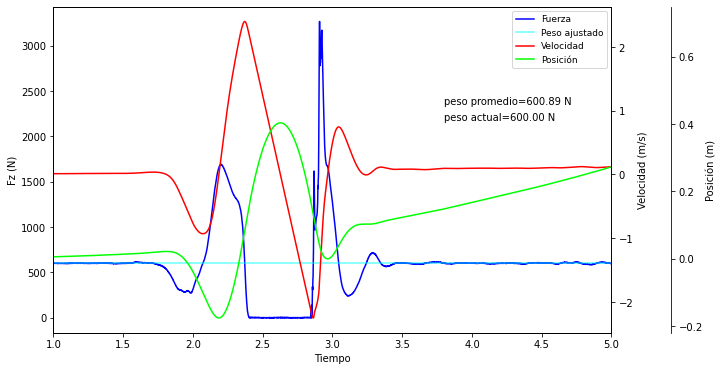

In [ ]:
#@title Efecto del ajuste del peso en los cálculos{ run: "auto" }
ajuste_peso = 600 #@param {type:"slider", min:570, max:630, step:0.5}

a=(Fz-ajuste_peso)/(ajuste_peso/9.8)
v= integrate.cumtrapz(a, dx=1/frec, initial=0)
p=integrate.cumtrapz(v, dx=1/frec, initial=0)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, Fz, 'b', label='Fuerza')
ax.axhline(ajuste_peso, color='cyan', alpha=0.6, label='Peso ajustado')

ax2 = ax.twinx() #crea el segundo eje
ax2.plot(t, v, 'r', label='Velocidad')

ax3 = ax.twinx() #crea el segundo eje
ax3.plot(t, p, 'lime', label='Posición')

ax.text(0.7, 0.7, 'peso promedio={0:.2f} N'.format(peso), transform=ax.transAxes) 
ax.text(0.7, 0.65, 'peso actual={0:.2f} N'.format(ajuste_peso), transform=ax.transAxes) 

#Ajusta el eje de la posición
ax3.spines['right'].set_position(('outward', 60)) #aleja hacia la derecha el eje 3
ax3.spines["right"].set_visible(True) #estos tres enprincipio no parecen necesarios
ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')

ax.set_xlabel('Tiempo')
ax.set_ylabel('Fz (N)')
ax2.set_ylabel('Velocidad (m/s)')
ax3.set_ylabel('Posición (m)')

#Ajusta límites del eje X
ax.set_xlim(1, 5)

fig.legend(fontsize=9, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()


Es por eso que debemos ser extremadamente cuidadosos con el cálculo del peso en cada salto.

# Cálculo de variables relacionadas con la fuerza

## Cálculo de la potencia

Una de las variables más interesantes en un salto vertical es la potencia, que se puede calcular a partir de la siguiente fórmula:

$P=F \times v$

siendo $F$ la fuerza vertical y $v$ la velocidad, dos variables que ya tenemos calculadas previamente.

La potencia es un buen indicador de la capacidad de aplicar fuerza rápidamente.

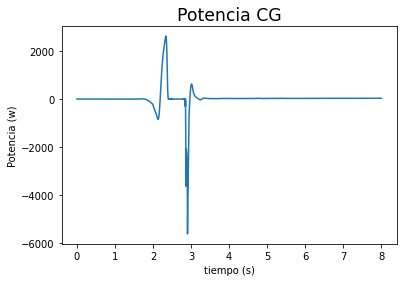

In [ ]:
potencia = Fz*veloc

plt.plot(t, potencia)
plt.xlabel('tiempo (s)')
plt.ylabel('Potencia (w)')
plt.title('Potencia CG', fontsize='xx-large')
plt.show()

Además, el signo de la potencia nos indica el tipo de contracción muscular que se está realizando: potencia positiva significa contracción concéntrica; potencia negativa significa contracción excéntrica.

En la siguiente gráfica se muestra en verde las zonas del salto en las que se realiza contracción concéntrica y en rojo contracción excéntrica.

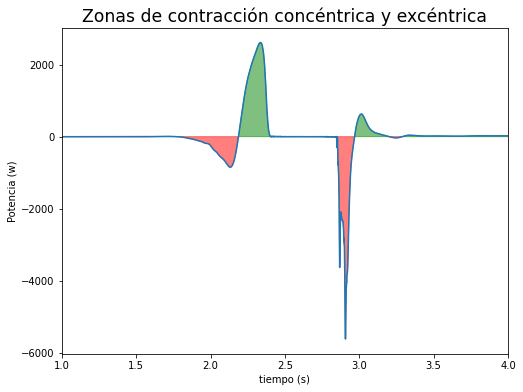

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(t, potencia)

ax.fill_between(t, 0, potencia, where= potencia>0.0, color='g', alpha=0.5) #rellena potencia positiva
ax.fill_between(t, 0, potencia, where= potencia<0.0, color='r', alpha=0.5) #rellena potencia negativa

#Ajusta límites del eje X
ax.set_xlim(fin_peso/frec, 4.0)

plt.xlabel('tiempo (s)')
plt.ylabel('Potencia (w)')
plt.title('Zonas de contracción concéntrica y excéntrica', fontsize='xx-large')

plt.show()

Y algo aún más interesante es utilizar el mismo criterio del signo de la potencia para determinar **en la gráfica de la fuerza vertical, las zonas de contracción concéntrica y excéntrica**.

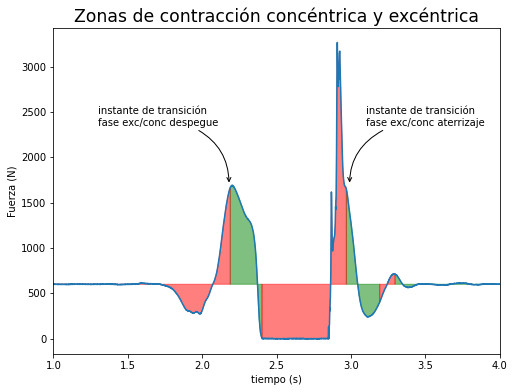

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(t, Fz)

ax.fill_between(t, peso, Fz, where= potencia>10.0, color='g', alpha=0.5) #rellena potencia positiva
ax.fill_between(t, peso, Fz, where= potencia<10.0, color='r', alpha=0.5) #rellena potencia negativa

#Ajusta límites del eje X
ax.set_xlim(fin_peso/frec, 4.0)

ax.annotate('instante de transición\nfase exc/conc despegue',
            xy=(2.18, 1700), xycoords='data',
            xytext=(0.1, 0.7), textcoords='axes fraction', #en este caso, las coordenadas del texto son relativas al tamaño del cuadro de los ejes (de 0 a 1)
            arrowprops=dict(arrowstyle='->', color='black', connectionstyle='angle3,angleA=-10,angleB=90')) #con algle3 se puede especificar el ángulo de la flecha al inicio y al final


ax.annotate('instante de transición\nfase exc/conc aterrizaje',
            xy=(2.99, 1700), xycoords='data',
            xytext=(0.7, 0.7), textcoords='axes fraction', #en este caso, las coordenadas del texto son relativas al tamaño del cuadro de los ejes (de 0 a 1)
            arrowprops=dict(arrowstyle='->', color='black', connectionstyle='angle3,angleA=10,angleB=90')) #con algle3 se puede especificar el ángulo de la flecha al inicio y al final


plt.xlabel('tiempo (s)')
plt.ylabel('Fuerza (N)')
plt.title('Zonas de contracción concéntrica y excéntrica', fontsize='xx-large')

plt.show()

En esta gráfica podemos confirmar que el primer pico de fuerza vertical en este saltador corresponde a la transición entre la fase excéntrica y concéntrica, es decir, **la posición más baja del centro de gravedad** durante la toma de impulso.
También se puede identificar esa posición después del aterrizaje en la amortiguación.

## Cálculo de la rapidez de producción de fuerza (RFD)

Esta varaible, RFD del inglés *Rate of Force Development*, representa lo rápido que puede ser un deportista aplicando fuerza, es decir, si cuánto es capaz de incrementar la fuerza que produce en un tiempo reducido. En un salto vertical el tiempo del que se dispone para aplicar fuerza antes de despegar es muy reducido, por lo que es importante poder aplicar mucha fuerza en muy poco tiempo.

Matemáticamente se calcula como la derivada de la fuerza respecto al tiempo:

$RFD= \frac{F}{dt}$

Se pude calcular fácilmente con funciones de *Numpy*.

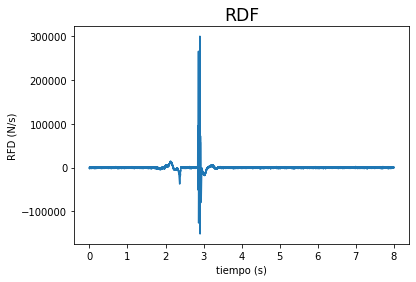

In [ ]:
#RFD, es la derivada de la fuerza respecto al tiempo
RFD = np.gradient(Fz)/(1/frec)

plt.plot(t, RFD)
plt.xlabel('tiempo (s)')
plt.ylabel('RFD (N/s)')
plt.title('RDF', fontsize='xx-large')
plt.show()

Esta varaible mantiene valores sobre una escala muy grande, especiamente los niveles que alcanza en el aterrizaje son muy grandes respecto a los del impulso inicial del salto, por lo que la vamos a representar solamente en la parte inicial. 

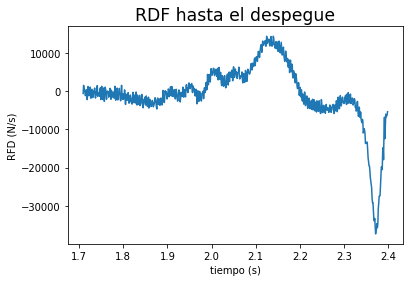

In [ ]:
#Limitamos la gráfica desde el inicio del salto hasta el despegue
plt.plot(t[ini_salto:despegue], RFD[ini_salto:despegue])
plt.xlabel('tiempo (s)')
plt.ylabel('RFD (N/s)')

plt.title('RDF hasta el despegue', fontsize='xx-large')
plt.show()

Normalmente, de esta variable nos interesaría el valor máximo hasta el despegue. Sin embargo, en un CMJ este valor suele encontrarse en la fase excéntrica y no es muy fiable porque depende mucho de la técnica del contramovimiento, es decir, si se desciende más o menos y la velocidad a la que se haga el descenso y su frenado. 

# Representación conjunta de todas las variables

Para facilitar la representación gráfica, metemos todos los resultados en un mismo *dataframe* de *Pandas*.

In [ ]:
DatosJuntos = pd.DataFrame({'t':t, 'Fz':Fz, 'Aceleracion':aceleracion, 'Velocidad':veloc, 'Posicion':posicion, 'Potencia':potencia, 'RFD':RFD})
#quitamos la parte final en la que no hay información relevante
DatosJuntos = DatosJuntos[:4000]
DatosJuntos

,t,Fz,Aceleracion,Velocidad,Posicion,Potencia,RFD
0,0.000,602.418762,0.024927,0.000000,0.000000e+00,0.000000,-1742.4920
1,0.001,600.676270,-0.003492,0.000011,5.358657e-09,0.006438,-1585.0295
2,0.002,599.248703,-0.026774,-0.000004,8.509403e-09,-0.002646,158.3630
3,0.003,600.992996,0.001674,-0.000017,-2.181609e-09,-0.010197,1665.0810
4,0.004,602.578865,0.027538,-0.000002,-1.184499e-08,-0.001422,554.3860
...,...,...,...,...,...,...,...
3995,3.995,602.229713,0.021843,0.039713,5.062561e-02,23.916187,-633.6860
3996,3.996,601.755257,0.014105,0.039731,5.066534e-02,23.908161,0.5725
3997,3.997,602.230858,0.021862,0.039749,5.070507e-02,23.937888,950.2255
3998,3.998,603.655708,0.045100,0.039782,5.074484e-02,24.014735,-554.1690


Una vez juntos en un mismo *dataframe*, se pueden presentar de distintas formas:

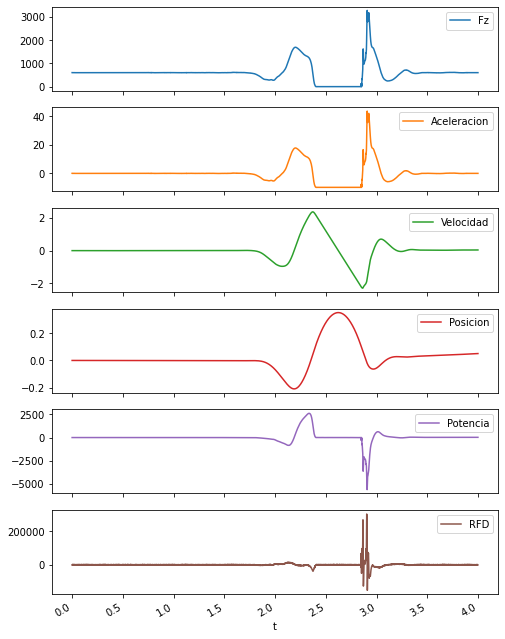

In [ ]:
DatosJuntos.plot(x='t', subplots=True, figsize=(8,12))
plt.show()

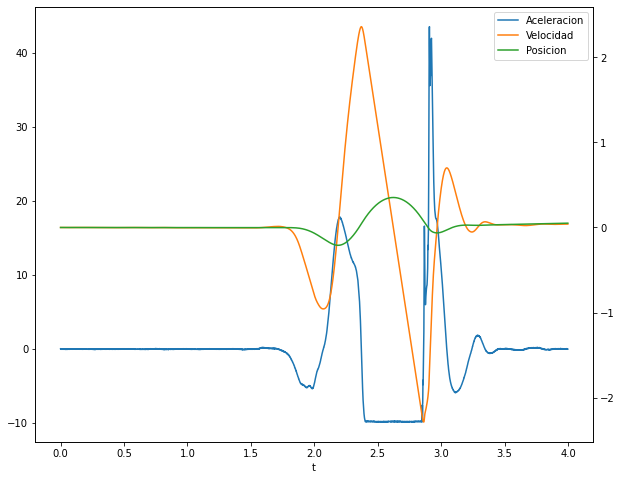

In [ ]:
DatosJuntos.plot(x='t', y=['Aceleracion', 'Velocidad', 'Posicion'], figsize=(10,8), secondary_y=['Velocidad', 'Posicion'], mark_right=False)
#ax.right_ax.set_ylabel('Velocidad (m/s), Posición (m)')

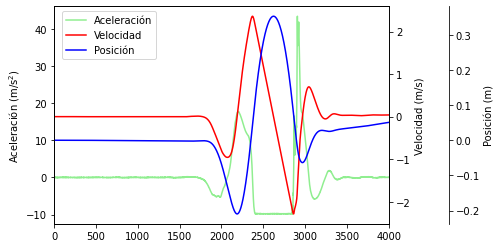

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx() #crea el segundo eje
ax3 = ax.twinx() #crea el segundo eje

ax.plot(aceleracion, 'lightgreen', label='Aceleración')
ax2.plot(veloc, 'r', label='Velocidad')
ax3.plot(posicion,'b', label='Posición')

ax.set_ylabel('Aceleración (m/s$^2$)')
ax2.set_ylabel('Velocidad (m/s)')
ax3.set_ylabel('Posición (m)')

#Ajusta límites del eje X
ax.set_xlim(0.0, 4000)

ax3.spines['right'].set_position(('outward', 60)) #aleja hacia la derecha el eje 3

fig.legend(bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes) #en este caso la leyenda hay que ponerla así para que incluya todos los ejes

plt.show()

# Otros gráficos de relación de variables

A continuación se presentan algunos gráficos que relacionan pares de variables, que pueden ser de utilidad.

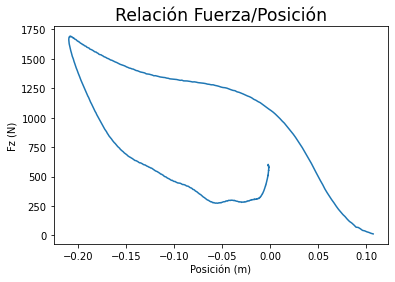

In [ ]:
fig, ax = plt.subplots()
ax.plot(posicion[ini_salto:despegue], Fz[ini_salto:despegue])
ax.set_xlabel('Posición (m)')
ax.set_ylabel('Fz (N)')
plt.title('Relación Fuerza/Posición', fontsize='xx-large')
plt.show()

Respecto al modelado de la curva Fuerza/Posición, consultar Linthorne (2021) para más información.
"A sharper decrease in ground reaction force toward the end of the upward propulsion phase could arise from a more optimal timing of the proximal-distal extension of the hip, knee, and ankle joints. In the simple countermovement jump model used in the present study (Figure 3; Equation (2)), a sharper decrease in ground reaction force is equivalent to a greater power exponent, A. A greater A results in a greater peak power and a higher position of the jumper’s centre of mass at peak power. Therefore, a higher position at peak power might be an indicator of a superior jumping technique where the athlete has greater ability to produce force toward the end of the take-off".



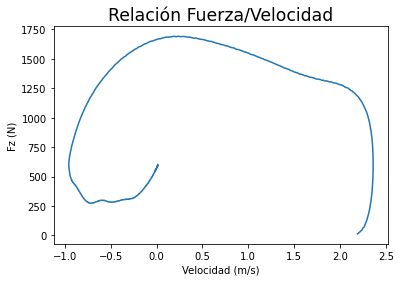

In [ ]:
fig, ax = plt.subplots()
ax.plot(veloc[ini_salto:despegue], Fz[ini_salto:despegue])
ax.set_xlabel('Velocidad (m/s)')
ax.set_ylabel('Fz (N)')
plt.title('Relación Fuerza/Velocidad', fontsize='xx-large')
plt.show()

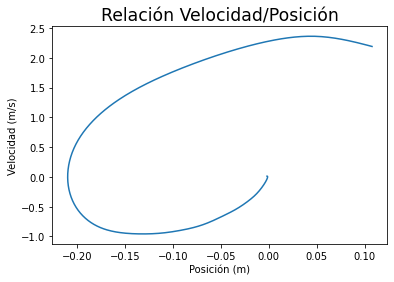

In [ ]:
fig, ax = plt.subplots()
ax.plot(posicion[ini_salto:despegue], veloc[ini_salto:despegue])
ax.set_xlabel('Posición (m)')
ax.set_ylabel('Velocidad (m/s)')
plt.title('Relación Velocidad/Posición', fontsize='xx-large')
plt.show()

#Bibliografía

Linthorne, N. P. (2001). Analysis of standing vertical jumps using a force platform. *American Journal of Physics*, 69(11), 1198–1204. https://doi.org/10.1119/1.1397460

Linthorne, N. P. (2021). The correlation between jump height and mechanical power in a countermovement jump is artificially inflated. *Sports Biomechanics*, 20(1), 3–21. https://doi.org/10.1080/14763141.2020.1721737

López Elvira, J. L. (1998). *Desarrollo de un nuevo software para el cálculo de la potencia mecánica en el salto con plataforma de fuerzas. Estudio de la reproducibilidad de los valores obtenidos en diversos tests de saltos*. Tesina Grado de Licenciado. Universidad de León.